**Table of Contents**  
[Parameters](#parameters)  
[Data preparation](#data_preparation)  
&nbsp; &nbsp; &nbsp; &nbsp;[Data loading](#data_loading)  
&nbsp; &nbsp; &nbsp; &nbsp;[Median normalization](#median_normalization)  
[Dimensionality reduction](#dimensionality_reduction)  
&nbsp; &nbsp; &nbsp; &nbsp;[PCA](#pca)  
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;[Principal component analysis](#principal_component_analysis)  
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;[Permutation](#permutation)  
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;[Batch effect removal](#batch_effect_removal)  
&nbsp; &nbsp; &nbsp; &nbsp;[t-SNE](#t-sne)  
&nbsp; &nbsp; &nbsp; &nbsp;[UMAP](#umap)  
&nbsp; &nbsp; &nbsp; &nbsp;[FIt-SNE](#fit-sne)  
&nbsp; &nbsp; &nbsp; &nbsp;[PHATE](#phate)  
&nbsp; &nbsp; &nbsp; &nbsp;[UMAP; min_dist=0.1](#umap;_min_dist=0.1)  
&nbsp; &nbsp; &nbsp; &nbsp;[MulticoreTSNE](#multicoretsne)  
[Clustering](#clustering)  
[Visualization](#visualization)  
&nbsp; &nbsp; &nbsp; &nbsp;[Cluster embedding](#cluster_embedding)  
&nbsp; &nbsp; &nbsp; &nbsp;[Cluster_distribution](#cluster_distribution)  
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;[Batch](#batch)  
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;[Batch (reversed)](#batch_reversed)  
&nbsp; &nbsp; &nbsp; &nbsp;[Expression](#expression)  

In [1]:
!date +%F

2020-07-21


In [2]:
import sys
sys.path.append('/Users/jialei/Dropbox/Data/Projects/UTSW/Scripts/utilities')
sys.path.append('/project/GCRB/Hon_lab/s166631/00.bin/utilities/')

In [3]:
import re
from pathlib import Path

In [4]:
import scipy.sparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib import __version__ as mpl_version
from sklearn import __version__ as sklearn_version

In [5]:
print(sys.version)
print('numpy', np.__version__)
print('pandas', pd.__version__)
print('scipy', scipy.__version__)
print('sklearn', sklearn_version)
print('matplotlib', mpl_version)
print('seaborn', sns.__version__)

3.7.4 (default, Aug 13 2019, 20:35:49) 
[GCC 7.3.0]
numpy 1.18.1
pandas 1.0.3
scipy 1.4.1
sklearn 0.22.1
matplotlib 3.2.1
seaborn 0.10.1


In [6]:
# sc.logging.print_versions()
import umap
import phate
import scanpy as sc
import harmonypy as hm
from fast_tsne import fast_tsne
from MulticoreTSNE import MulticoreTSNE as TSNE_

print('scanpy', sc.__version__)
print('umap', umap.__version__)
print('phate', phate.__version__)

/home2/s166631/.conda/envs/py37/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


scanpy 1.5.1
umap 0.4.3
phate 1.0.4


In [7]:
# mpl.rcParams.update(mpl.rcParamsDefault)
# plt.rcParams

params = {'pdf.fonttype': 42,
          'font.family': 'sans-serif',
          'font.sans-serif': 'Arial',
          'mathtext.default': 'regular',
          'figure.dpi': 96 * 1.5,
          'axes.axisbelow': True}
plt.rcParams.update(params)

%config InlineBackend.figure_format = 'retina'

In [8]:
from utilities import (
    open_file,
    read_10x_matrix,
    plot_pca_variance_explained,
    plot_embedding,
    extract_feature_values,
    plot_embedding_expr,
    prepare_cluster_composition,
    plot_cluster_composition
)

<a id='parameters'></a>

# Parameters

In [9]:
DATA_DIR = Path('.')
MIN_GENES_THRESHOLD = 200

SEED_USE = 20200317
N_COMPONENTS = 50
N_REPLICATES = 10
PROPORTION_OF_VARS = 0.1
MINIMAL_NUM_CELLS_REQUIRED_FOR_GENE = 30
MINIMAL_NUM_COUNTS_REQUIRED_FOR_GENE = 60

N_COMPONENTS_SELECTED = 30

<a id='data_preparation'></a>

# Data preparation

<a id='data_loading'></a>

## Data loading

In [10]:
matrix_readcount_use = scipy.sparse.load_npz(
    file=DATA_DIR / 'matrix_readcount.npz')

matrix_readcount_use_barcodes = np.load(
    file=DATA_DIR / 'matrix_readcount_barcodes.npy')

matrix_readcount_use_features = np.load(
    file=DATA_DIR / 'matrix_readcount_features.npy')

matrix_readcount_use = \
    matrix_readcount_use[:, np.argsort(a=matrix_readcount_use_barcodes)]
matrix_readcount_use_barcodes = matrix_readcount_use_barcodes[np.argsort(
    a=matrix_readcount_use_barcodes)]

In [11]:
matrix_readcount_use.shape

(27998, 89773)

<a id='median_normalization'></a>

## Median normalization

In [12]:
matrix_readcount_norm = matrix_readcount_use.copy()
print(
    'Raw median UMIs per cell:',
    f'{np.median(a=matrix_readcount_use.sum(axis=0).A1)}'
)

Raw median UMIs per cell: 7876.0


In [13]:
print(f'Number of cells before filtering: {matrix_readcount_norm.shape[1]}')
print(f'Number of features before filtering: {matrix_readcount_norm.shape[0]}')

Number of cells before filtering: 89773
Number of features before filtering: 27998


In [14]:
# filter cells
(col_idx,) = np.where(
    (matrix_readcount_norm > 0).sum(axis=0).A1 >= MIN_GENES_THRESHOLD
)

matrix_readcount_norm = matrix_readcount_norm[:, col_idx]
matrix_readcount_norm_barcodes = matrix_readcount_use_barcodes[col_idx]
print(
    f'Number of cells after filtering: {len(matrix_readcount_norm_barcodes)}')

Number of cells after filtering: 89773


In [15]:
# filter features
row_idx = np.logical_and(
    (matrix_readcount_norm > 0).sum(
        axis=1).A1 >= MINIMAL_NUM_CELLS_REQUIRED_FOR_GENE,
    (matrix_readcount_norm).sum(axis=1).A1 >= MINIMAL_NUM_COUNTS_REQUIRED_FOR_GENE,
)

matrix_readcount_norm = matrix_readcount_norm[row_idx, :]
matrix_readcount_norm_features = matrix_readcount_use_features[row_idx]
print(
    f'Number of features after filtering: {len(matrix_readcount_norm_features)}')
print(
    'After filtering, median UMIs per cell is',
    f'{np.median(a=matrix_readcount_norm.sum(axis=0).A1)}'
)

Number of features after filtering: 19495
After filtering, median UMIs per cell is 7875.0


In [16]:
# normalize
matrix_readcount_norm.data = (
    np.median(a=matrix_readcount_norm.sum(axis=0).A1)
    * matrix_readcount_norm.data
    / np.repeat(matrix_readcount_norm.sum(axis=0).A1,
                np.diff(matrix_readcount_norm.indptr))
)

<a id='dimensionality_reduction'></a>

# Dimensionality reduction

In [17]:
# create anndata object, logarithmized
adata = sc.AnnData(
    X=np.log1p(matrix_readcount_norm.T),
    obs={
        'cell': matrix_readcount_norm_barcodes,
        'batch': [re.sub('_[A-Z]{16}$', '', i)
                  for i in matrix_readcount_norm_barcodes],
    },
    var={'feature': matrix_readcount_norm_features},
)
adata.obs.index = adata.obs['cell']
adata.var.index = adata.var['feature']

In [18]:
# standardize
sc.pp.scale(adata, zero_center=True, max_value=None, copy=False)

<a id='pca'></a>

## PCA

<a id='principal_component_analysis'></a>

### Principal component analysis

In [19]:
pca = PCA(
    n_components=N_COMPONENTS,
    copy=True,
    whiten=False,
    svd_solver='arpack',
    tol=0.0,
    iterated_power='auto',
    random_state=SEED_USE,
)

principal_components = pca.fit_transform(adata.X)

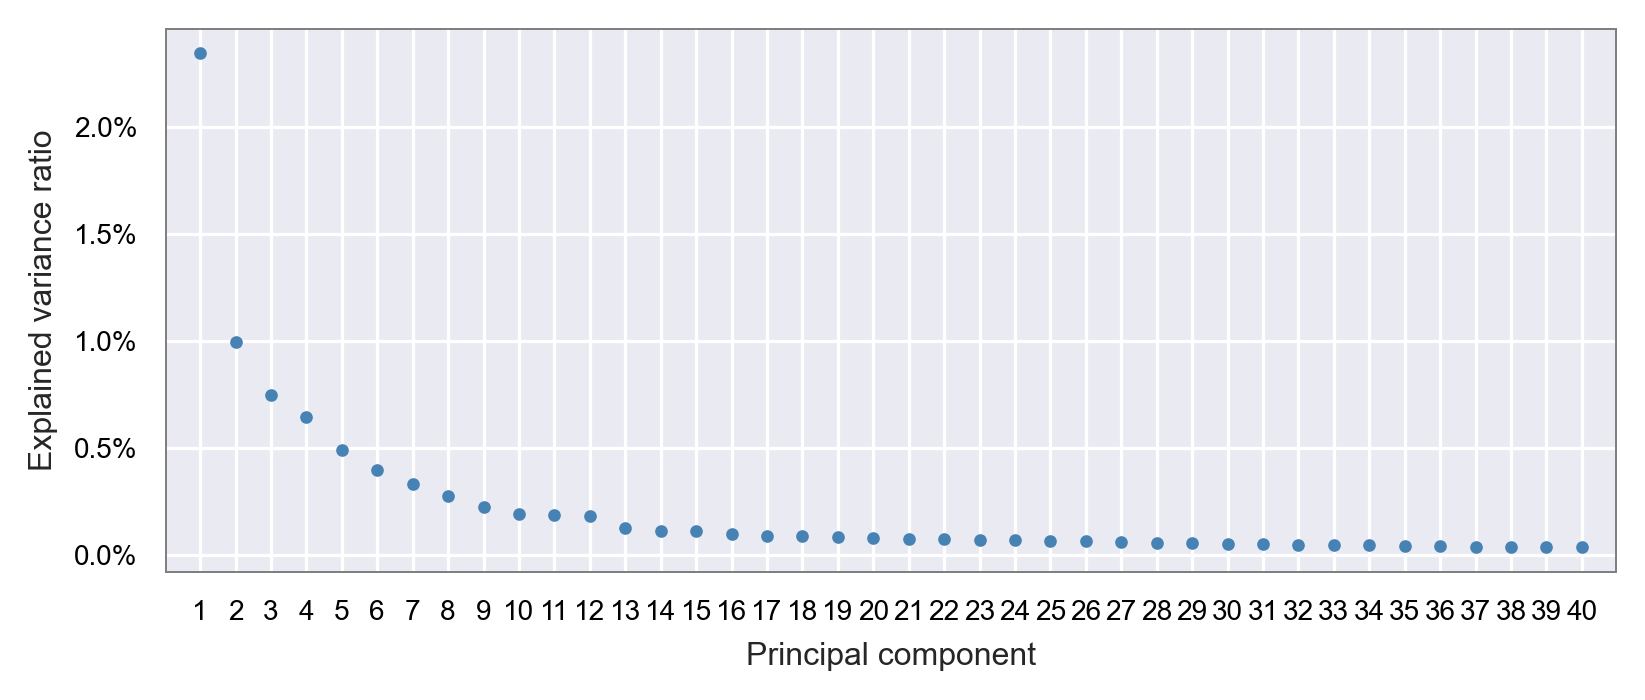

In [20]:
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6.5, 2.5))

    plot_pca_variance_explained(
        explained_variance_ratio=pca.explained_variance_ratio_,
        maximum_num_pcs=40,
        ax=ax
    )

In [21]:
file_name = ('Pyplot_pca_explained_var_ratio'
             + '_seed'
             + str(SEED_USE)
             + '.pdf')

if not Path(file_name).is_file():
    fig.savefig(fname=file_name, transparent=None, bbox_inches='tight')

In [22]:
file_name = ('principal_components'
             + '_ncomponents'
             + str(N_COMPONENTS)
             + '_seed'
             + str(SEED_USE)
             + '.npy')

if not Path(file_name).is_file():
    np.save(
        file=file_name,
        arr=principal_components,
        allow_pickle=False
    )

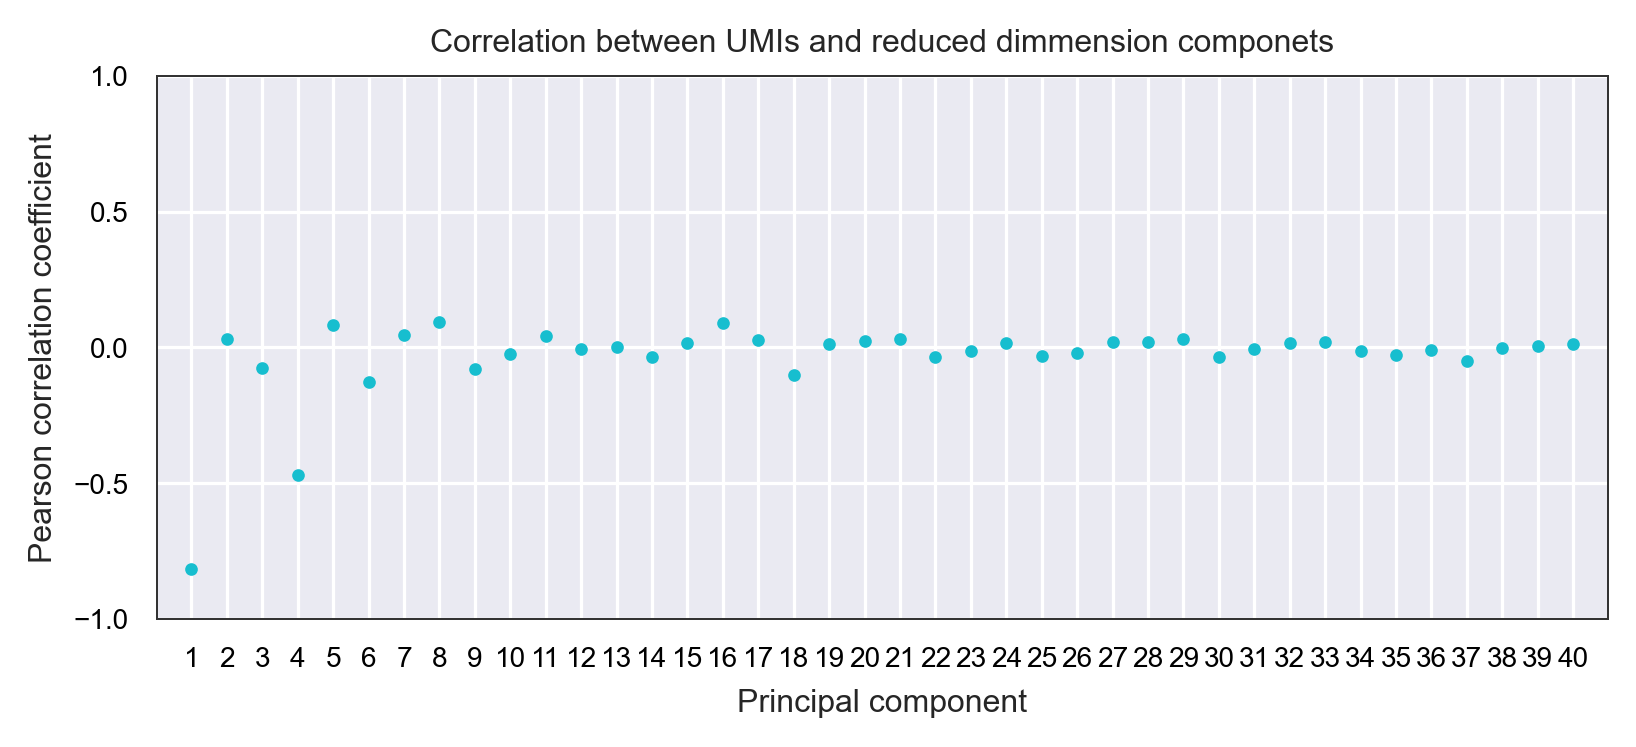

In [23]:
# Correlation between UMIs and reduced dimmension componets

N_COMPONENTS_CORR = min(40, N_COMPONENTS)
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6.5, 2.5))

ax.scatter(
    x=range(N_COMPONENTS_CORR),
    y=[scipy.stats.pearsonr(
        x=principal_components[:, i],
        y=np.log1p(matrix_readcount_use[:, col_idx].sum(axis=0).A1),
    )[0] for i in range(N_COMPONENTS_CORR)],
    s=40,
    c='tab:cyan',
    marker='.',
    # cmap='viridis',
    vmin=0,
    vmax=None,
    alpha=1,
    linewidth=0,
    edgecolors=None,
)

ax.tick_params(labelsize=7, labelcolor='black')
ax.set_xticks(ticks=range(N_COMPONENTS_CORR))
ax.set_xticklabels(labels=[str(i + 1) for i in ax.get_xticks()])

ax.set_ylim(bottom=-1, top=1)
ax.set_yticks(
    ticks=np.linspace(
        start=-1,
        stop=1,
        num=5,
        endpoint=True
    ))

ax.set_title(
    label='Correlation between UMIs and reduced dimmension componets',
    fontsize=8,
    loc='center'
)
ax.set_xlabel('Principal component', fontsize=8)
ax.set_ylabel('Pearson correlation coefficient', fontsize=8)

ax.margins(x=0.025, y=0.025)

for i in ['top', 'bottom', 'left', 'right']:
    ax.spines[i].set_linewidth(w=0.5)
    ax.spines[i].set_color(c='#333333')

In [24]:
file_name = ('Pyplot_correlation_umis_and_reduced_dimmension_componets'
             + '_ncomponents'
             + str(N_COMPONENTS)
             + '_seed'
             + str(SEED_USE)
             + '.pdf')

if not Path(file_name).is_file():
    fig.savefig(fname=file_name, transparent=None, bbox_inches='tight')

<a id='permutation'></a>

### Permutation

In [25]:
N_OF_VARS = round(number=adata.n_vars * PROPORTION_OF_VARS)
summarized_permutations = np.zeros(shape=(N_REPLICATES, N_COMPONENTS))

for i in range(N_REPLICATES):
    print(i)

    permutation_matrix = adata.X.copy()
    vars_selected_idx = np.random.choice(
        a=range(permutation_matrix.shape[1]), size=N_OF_VARS
    )

    permutation_matrix[:, vars_selected_idx] = np.random.permutation(
        permutation_matrix[:, vars_selected_idx]
    )

    pca_perm = PCA(
        n_components=N_COMPONENTS,
        copy=True,
        whiten=False,
        svd_solver='arpack',
        tol=0.0,
        iterated_power='auto',
        random_state=SEED_USE,
    )

    principal_components_perm = pca_perm.fit_transform(permutation_matrix)
    summarized_permutations[i, :] = pca_perm.explained_variance_ratio_

pca.explained_variance_ratio_ > np.mean(summarized_permutations, axis=0)

print(
    pd.Series(
        pca.explained_variance_ratio_ > np.mean(
            summarized_permutations,
            axis=0
        ),
        index=range(1, N_COMPONENTS + 1)
    )
)

0
1
2
3
4
5
6
7
8
9
1      True
2      True
3      True
4      True
5      True
6      True
7      True
8      True
9     False
10    False
11     True
12     True
13    False
14    False
15     True
16    False
17    False
18    False
19    False
20     True
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30    False
31    False
32    False
33    False
34    False
35    False
36    False
37    False
38    False
39    False
40    False
41    False
42    False
43    False
44    False
45    False
46    False
47    False
48    False
49    False
50    False
dtype: bool


In [26]:
N_COMPONENTS_SELECTED = (
    max(
        np.where(
            pca.explained_variance_ratio_ > np.median(
                summarized_permutations, axis=0)
        )[0]
    ) + 1
)
print(N_COMPONENTS_SELECTED)

20


<a id='batch_effect_removal'></a>

### Batch effect removal

In [27]:
batches = adata.obs['batch'].values

pd.Series(
    data=batches
).value_counts().to_frame(name='num_cells')

num_cells
SRR10480618       9874
SRR10480626       8482
SRR10480622       8044
SRR10480623       7994
SRR10480628       7915
SRR10480620       7894
SRR10480624       7534
SRR10480621       6989
SRR10480627       6852
SRR10480619       6662
SRR10480629       6468
SRR10480625       5065

In [28]:
if len(set(batches)) > 1:

    ho = hm.run_harmony(
        data_mat=principal_components,
        meta_data=pd.DataFrame(
            {'batch': batches},
            index=matrix_readcount_norm_barcodes),
        vars_use='batch',
        random_state=SEED_USE
    )
    principal_components_corrected = ho.Z_corr.T

else:
    principal_components_corrected = principal_components

2020-07-21 18:14:20,513 - harmonypy - INFO - Iteration 1 of 10
2020-07-21 18:14:41,256 - harmonypy - INFO - Iteration 2 of 10
2020-07-21 18:15:02,196 - harmonypy - INFO - Iteration 3 of 10
2020-07-21 18:15:22,992 - harmonypy - INFO - Iteration 4 of 10
2020-07-21 18:15:43,754 - harmonypy - INFO - Iteration 5 of 10
2020-07-21 18:16:04,634 - harmonypy - INFO - Iteration 6 of 10
2020-07-21 18:16:25,429 - harmonypy - INFO - Iteration 7 of 10
2020-07-21 18:16:45,979 - harmonypy - INFO - Iteration 8 of 10
2020-07-21 18:17:04,911 - harmonypy - INFO - Iteration 9 of 10
2020-07-21 18:17:17,040 - harmonypy - INFO - Iteration 10 of 10
2020-07-21 18:17:29,203 - harmonypy - INFO - Stopped before convergence


In [29]:
N_COMPONENTS_SELECTED = 15

In [30]:
principal_components_use = principal_components_corrected[:, range(N_COMPONENTS_SELECTED)]
principal_components_use.shape

(89773, 15)

<a id='t-sne'></a>

## t-SNE

In [31]:
# t-SNE
embedding_tsne = TSNE(
    n_components=2,
    perplexity=30.0,
    early_exaggeration=12.0,
    learning_rate=200.0,
    n_iter=3000,
    n_iter_without_progress=300,
    min_grad_norm=1e-07,
    metric='euclidean',
    init='random',
    verbose=1,
    random_state=SEED_USE,
    method='barnes_hut',
    angle=0.5,
).fit_transform(principal_components_use)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 89773 samples in 0.194s...
[t-SNE] Computed neighbors for 89773 samples in 37.801s...
[t-SNE] Computed conditional probabilities for sample 1000 / 89773
[t-SNE] Computed conditional probabilities for sample 2000 / 89773
[t-SNE] Computed conditional probabilities for sample 3000 / 89773
[t-SNE] Computed conditional probabilities for sample 4000 / 89773
[t-SNE] Computed conditional probabilities for sample 5000 / 89773
[t-SNE] Computed conditional probabilities for sample 6000 / 89773
[t-SNE] Computed conditional probabilities for sample 7000 / 89773
[t-SNE] Computed conditional probabilities for sample 8000 / 89773
[t-SNE] Computed conditional probabilities for sample 9000 / 89773
[t-SNE] Computed conditional probabilities for sample 10000 / 89773
[t-SNE] Computed conditional probabilities for sample 11000 / 89773
[t-SNE] Computed conditional probabilities for sample 12000 / 89773
[t-SNE] Computed conditional probabilities for sa

<a id='umap'></a>

## UMAP

In [32]:
embedding_umap = umap.UMAP(
    n_neighbors=15,
    n_components=2,
    metric='euclidean',
    min_dist=0.5,
    spread=1.0,
    random_state=SEED_USE,
    transform_seed=42,
    verbose=True,
).fit_transform(principal_components_use)

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.5, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=20200317, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Tue Jul 21 18:29:26 2020 Finding Nearest Neighbors
Tue Jul 21 18:29:26 2020 Building RP forest with 20 trees
Tue Jul 21 18:29:28 2020 NN descent for 16 iterations
	 0  /  16
	 1  /  16
	 2  /  16
Tue Jul 21 18:29:43 2020 Finished Nearest Neighbor Search
Tue Jul 21 18:29:46 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20 

<a id='fit-sne'></a>

## FIt-SNE

In [33]:
embedding_initialization = umap.UMAP(
    n_neighbors=15,
    n_components=N_COMPONENTS,
    metric='euclidean',
    min_dist=0.1,
    spread=1.0,
    random_state=SEED_USE,
    transform_seed=42,
    verbose=True
).fit_transform(principal_components_use)


embedding_fitsne = fast_tsne(
    X=principal_components_use,
    map_dims=2,
    perplexity=30,
    initialization=embedding_initialization,
    seed=SEED_USE,
    max_iter=2000,
    df=1.0,
    nthreads=15,
)

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=50, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=20200317, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Tue Jul 21 18:31:31 2020 Finding Nearest Neighbors
Tue Jul 21 18:31:31 2020 Building RP forest with 20 trees
Tue Jul 21 18:31:31 2020 NN descent for 16 iterations
	 0  /  16
	 1  /  16
	 2  /  16
Tue Jul 21 18:31:38 2020 Finished Nearest Neighbor Search
Tue Jul 21 18:31:39 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20

<a id='phate'></a>

## PHATE

In [34]:
embedding_phate = phate.PHATE(
    n_components=2,
    knn=10,
    n_pca=N_COMPONENTS_SELECTED,
    mds_solver='smacof',
    n_jobs=-2,
    random_state=SEED_USE
).fit_transform(np.sqrt(matrix_readcount_norm.T))

Calculating PHATE...
  Running PHATE on 89773 observations and 19495 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...


/home2/s166631/.conda/envs/py37/lib/python3.7/site-packages/graphtools/base.py:130: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):


    Calculated PCA in 70.62 seconds.
    Calculating KNN search...
    Calculated KNN search in 120.78 seconds.
    Calculating affinities...
    Calculated affinities in 2.51 seconds.
  Calculated graph and diffusion operator in 194.10 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 9.84 seconds.
    Calculating KMeans...
    Calculated KMeans in 26.45 seconds.
  Calculated landmark operator in 39.46 seconds.
  Calculating optimal t...
    Automatically selected t = 14
  Calculated optimal t in 0.90 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.28 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 14.74 seconds.
Calculated PHATE in 249.48 seconds.


<a id='umap;_min_dist=0.1'></a>

## UMAP; min_dist=0.1

In [35]:
embedding_umap2 = umap.UMAP(
    n_neighbors=10,
    n_components=2,
    metric='euclidean',
    min_dist=0.1,
    spread=1.0,
    random_state=SEED_USE,
    transform_seed=42,
    verbose=True,
).fit_transform(principal_components_use)

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=10, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=20200317, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Tue Jul 21 18:55:46 2020 Finding Nearest Neighbors
Tue Jul 21 18:55:46 2020 Building RP forest with 20 trees
Tue Jul 21 18:55:47 2020 NN descent for 16 iterations
	 0  /  16
	 1  /  16
	 2  /  16
Tue Jul 21 18:55:51 2020 Finished Nearest Neighbor Search
Tue Jul 21 18:55:51 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20 

<a id='multicoretsne'></a>

## MulticoreTSNE

In [36]:
embedding_tsne2 = TSNE_(
    n_components=2,
    perplexity=30.0,
    early_exaggeration=12,
    learning_rate=200,
    n_iter=200,
    n_iter_early_exag=250,
    n_iter_without_progress=30,
    min_grad_norm=1e-07,
    metric='euclidean',
    init='random',
    verbose=1,
    random_state=SEED_USE,
    method='barnes_hut',  # 'fft',
    angle=0.5,
    n_jobs=15,
    cheat_metric=True,
).fit_transform(principal_components_use)

<a id='clustering'></a>

# Clustering

In [37]:
adata = sc.AnnData(
    X=principal_components_use,
    obs={
        'cell': matrix_readcount_norm_barcodes,
        'batch': [re.sub('_[A-Z]{16}$', '', i)
                  for i in matrix_readcount_norm_barcodes],
    },
)

In [38]:
sc.pp.neighbors(
    adata=adata,
    n_neighbors=30,
    n_pcs=0,
    # use_rep=None,
    knn=True,
    random_state=SEED_USE,
    method='umap',
    metric='euclidean',
    copy=False,
)

In [39]:
sc.tl.louvain(
    adata=adata,
    resolution=None,
    random_state=SEED_USE,
    flavor='vtraag',
    directed=True,
    use_weights=False,
    partition_type=None,
    copy=False,
)

In [40]:
embedding = pd.DataFrame(
    data=np.concatenate(
        (
            adata.obs[['batch', 'louvain']],
            embedding_tsne,
            embedding_umap,
            embedding_fitsne,
            embedding_phate,
            embedding_umap2,
            embedding_tsne2
        ),
        axis=1,
    ),
    index=adata.obs['cell'],
    columns=[
        'batch',
        'louvain',
        'x_tsne',
        'y_tsne',
        'x_umap',
        'y_umap',
        'x_fitsne',
        'y_fitsne',
        'x_phate',
        'y_phate',
        'x_min_dist=0.1',
        'y_min_dist=0.1',
        'x_multicoretsne',
        'y_multicoretsne',
    ],
)

file_name = ('embedding_'
             + 'ncomponents'
             + str(N_COMPONENTS_SELECTED)
             + '_'
             + 'seed'
             + str(SEED_USE)
             + '.csv')

if not Path(file_name).is_file():
    embedding.to_csv(path_or_buf=file_name)

In [41]:
embedding = embedding.astype(
    {'louvain': int,
     'x_tsne': float,
     'y_tsne': float,
     'x_umap': float,
     'y_umap': float,
     'x_fitsne': float,
     'y_fitsne': float,
     'x_phate': float,
     'y_phate': float,

     'x_min_dist=0.1': float,
     'y_min_dist=0.1': float,
     'x_multicoretsne': float,
     'y_multicoretsne': float
     }
)

embedding.dtypes

batch               object
louvain              int64
x_tsne             float64
y_tsne             float64
x_umap             float64
y_umap             float64
x_fitsne           float64
y_fitsne           float64
x_phate            float64
y_phate            float64
x_min_dist=0.1     float64
y_min_dist=0.1     float64
x_multicoretsne    float64
y_multicoretsne    float64
dtype: object

In [42]:
embedding['louvain'].value_counts().to_frame(name='num_cells')

num_cells
0        8663
1        8343
2        6682
3        6534
4        6416
5        6218
6        6108
7        5457
8        5426
9        3868
10       3856
11       3433
12       3377
13       3287
14       2276
15       2263
16       1812
17       1644
18       1104
19        954
20        710
21        472
22        396
23        343
24         71
25         60

<a id='visualization'></a>

# Visualization

In [43]:
embedding

batch  louvain      x_tsne      y_tsne  \
cell                                                                         
SRR10480618_AAACCTGAGAATGTGT  SRR10480618        3  -63.544292   60.800129   
SRR10480618_AAACCTGAGATATGGT  SRR10480618       11   59.055851   42.950611   
SRR10480618_AAACCTGAGATCCCAT  SRR10480618        7  -41.468239 -110.822914   
SRR10480618_AAACCTGAGATGTGGC  SRR10480618        2  -33.752178  -25.530668   
SRR10480618_AAACCTGAGCAATCTC  SRR10480618        3  -36.917820   60.974411   
...                                   ...      ...         ...         ...   
SRR10480629_TTTGTCATCCGCAAGC  SRR10480629       16  -41.674286  125.261490   
SRR10480629_TTTGTCATCGAACTGT  SRR10480629        6   12.975117  -21.247423   
SRR10480629_TTTGTCATCGCATGGC  SRR10480629        9  -72.724480  -87.378990   
SRR10480629_TTTGTCATCGGTGTCG  SRR10480629        3  -11.355423   87.489021   
SRR10480629_TTTGTCATCTTTAGTC  SRR10480629       13 -117.350807   44.752602   

                                 x_umap     y_umap   x_fitsne    y_fitsne  \
cell                                                                        
SRR10480618_AAACCTGAGAATGTGT  -4.888644  10.854902  -5.592278  -34.337996   
SRR10480618_AAACCTGAGATATGGT  -1.236656  -0.128438 -20.344459   43.287486   
SRR10480618_AAACCTGAGATCCCAT  11.191449  16.853962   2.926764   99.914398   
SRR10480618_AAACCTGAGATGTGGC  -1.795511  15.261007 -61.509308  -64.454277   
SRR10480618_AAACCTGAGCAATCTC  -2.944507   8.243129  -2.264591  -56.902768   
...                                 ...        ...        ...         ...   
SRR10480629_TTTGTCATCCGCAAGC  -7.583933   8.821531  34.408245  -14.637911   
SRR10480629_TTTGTCATCGAACTGT  -3.524917  14.680882 -68.111195  -97.763634   
SRR10480629_TTTGTCATCGCATGGC   5.112689  -3.269164 -49.198851  114.224005   
SRR10480629_TTTGTCATCGGTGTCG  -2.549302   6.940813  29.910937  -66.252824   
SRR10480629_TTTGTCATCTTTAGTC   8.510673   6.407148  75.553942    3.751523   

                               x_phate   y_phate  x_min_dist=0.1  \
cell                                                               
SRR10480618_AAACCTGAGAATGTGT -0.020674 -0.005732        3.834412   
SRR10480618_AAACCTGAGATATGGT -0.007212  0.015510        6.856854   
SRR10480618_AAACCTGAGATCCCAT  0.029995  0.000329       19.241137   
SRR10480618_AAACCTGAGATGTGGC -0.015543 -0.011744        9.082065   
SRR10480618_AAACCTGAGCAATCTC -0.019511  0.001613        3.298746   
...                                ...       ...             ...   
SRR10480629_TTTGTCATCCGCAAGC -0.014468 -0.002034        1.107777   
SRR10480629_TTTGTCATCGAACTGT -0.017197 -0.008026        9.476127   
SRR10480629_TTTGTCATCGCATGGC  0.024237 -0.013848       12.857329   
SRR10480629_TTTGTCATCGGTGTCG -0.018968  0.000737        2.647511   
SRR10480629_TTTGTCATCTTTAGTC  0.028122  0.007177       13.983206   

                              y_min_dist=0.1  x_multicoretsne  y_multicoretsne  
cell                                                                            
SRR10480618_AAACCTGAGAATGTGT        9.285891         0.098055         0.646295  
SRR10480618_AAACCTGAGATATGGT       -3.533564        -0.132511        -0.679680  
SRR10480618_AAACCTGAGATCCCAT        4.184856         2.051294        -1.083437  
SRR10480618_AAACCTGAGATGTGGC        5.367610        -0.937811         0.762136  
SRR10480618_AAACCTGAGCAATCTC        7.369936         0.666196        -0.183468  
...                                      ...              ...              ...  
SRR10480629_TTTGTCATCCGCAAGC        9.948415        -0.362860         0.131109  
SRR10480629_TTTGTCATCGAACTGT        7.227737         0.215743         0.999299  
SRR10480629_TTTGTCATCGCATGGC       -9.151089        -1.196235        -2.322638  
SRR10480629_TTTGTCATCGGTGTCG        7.014710         0.930393        -0.503713  
SRR10480629_TTTGTCATCTTTAGTC       -4.500890        -1.646089         1.823316  

[89773 rows x 14 columns]

<a id='cluster_embedding'></a>

## Cluster embedding

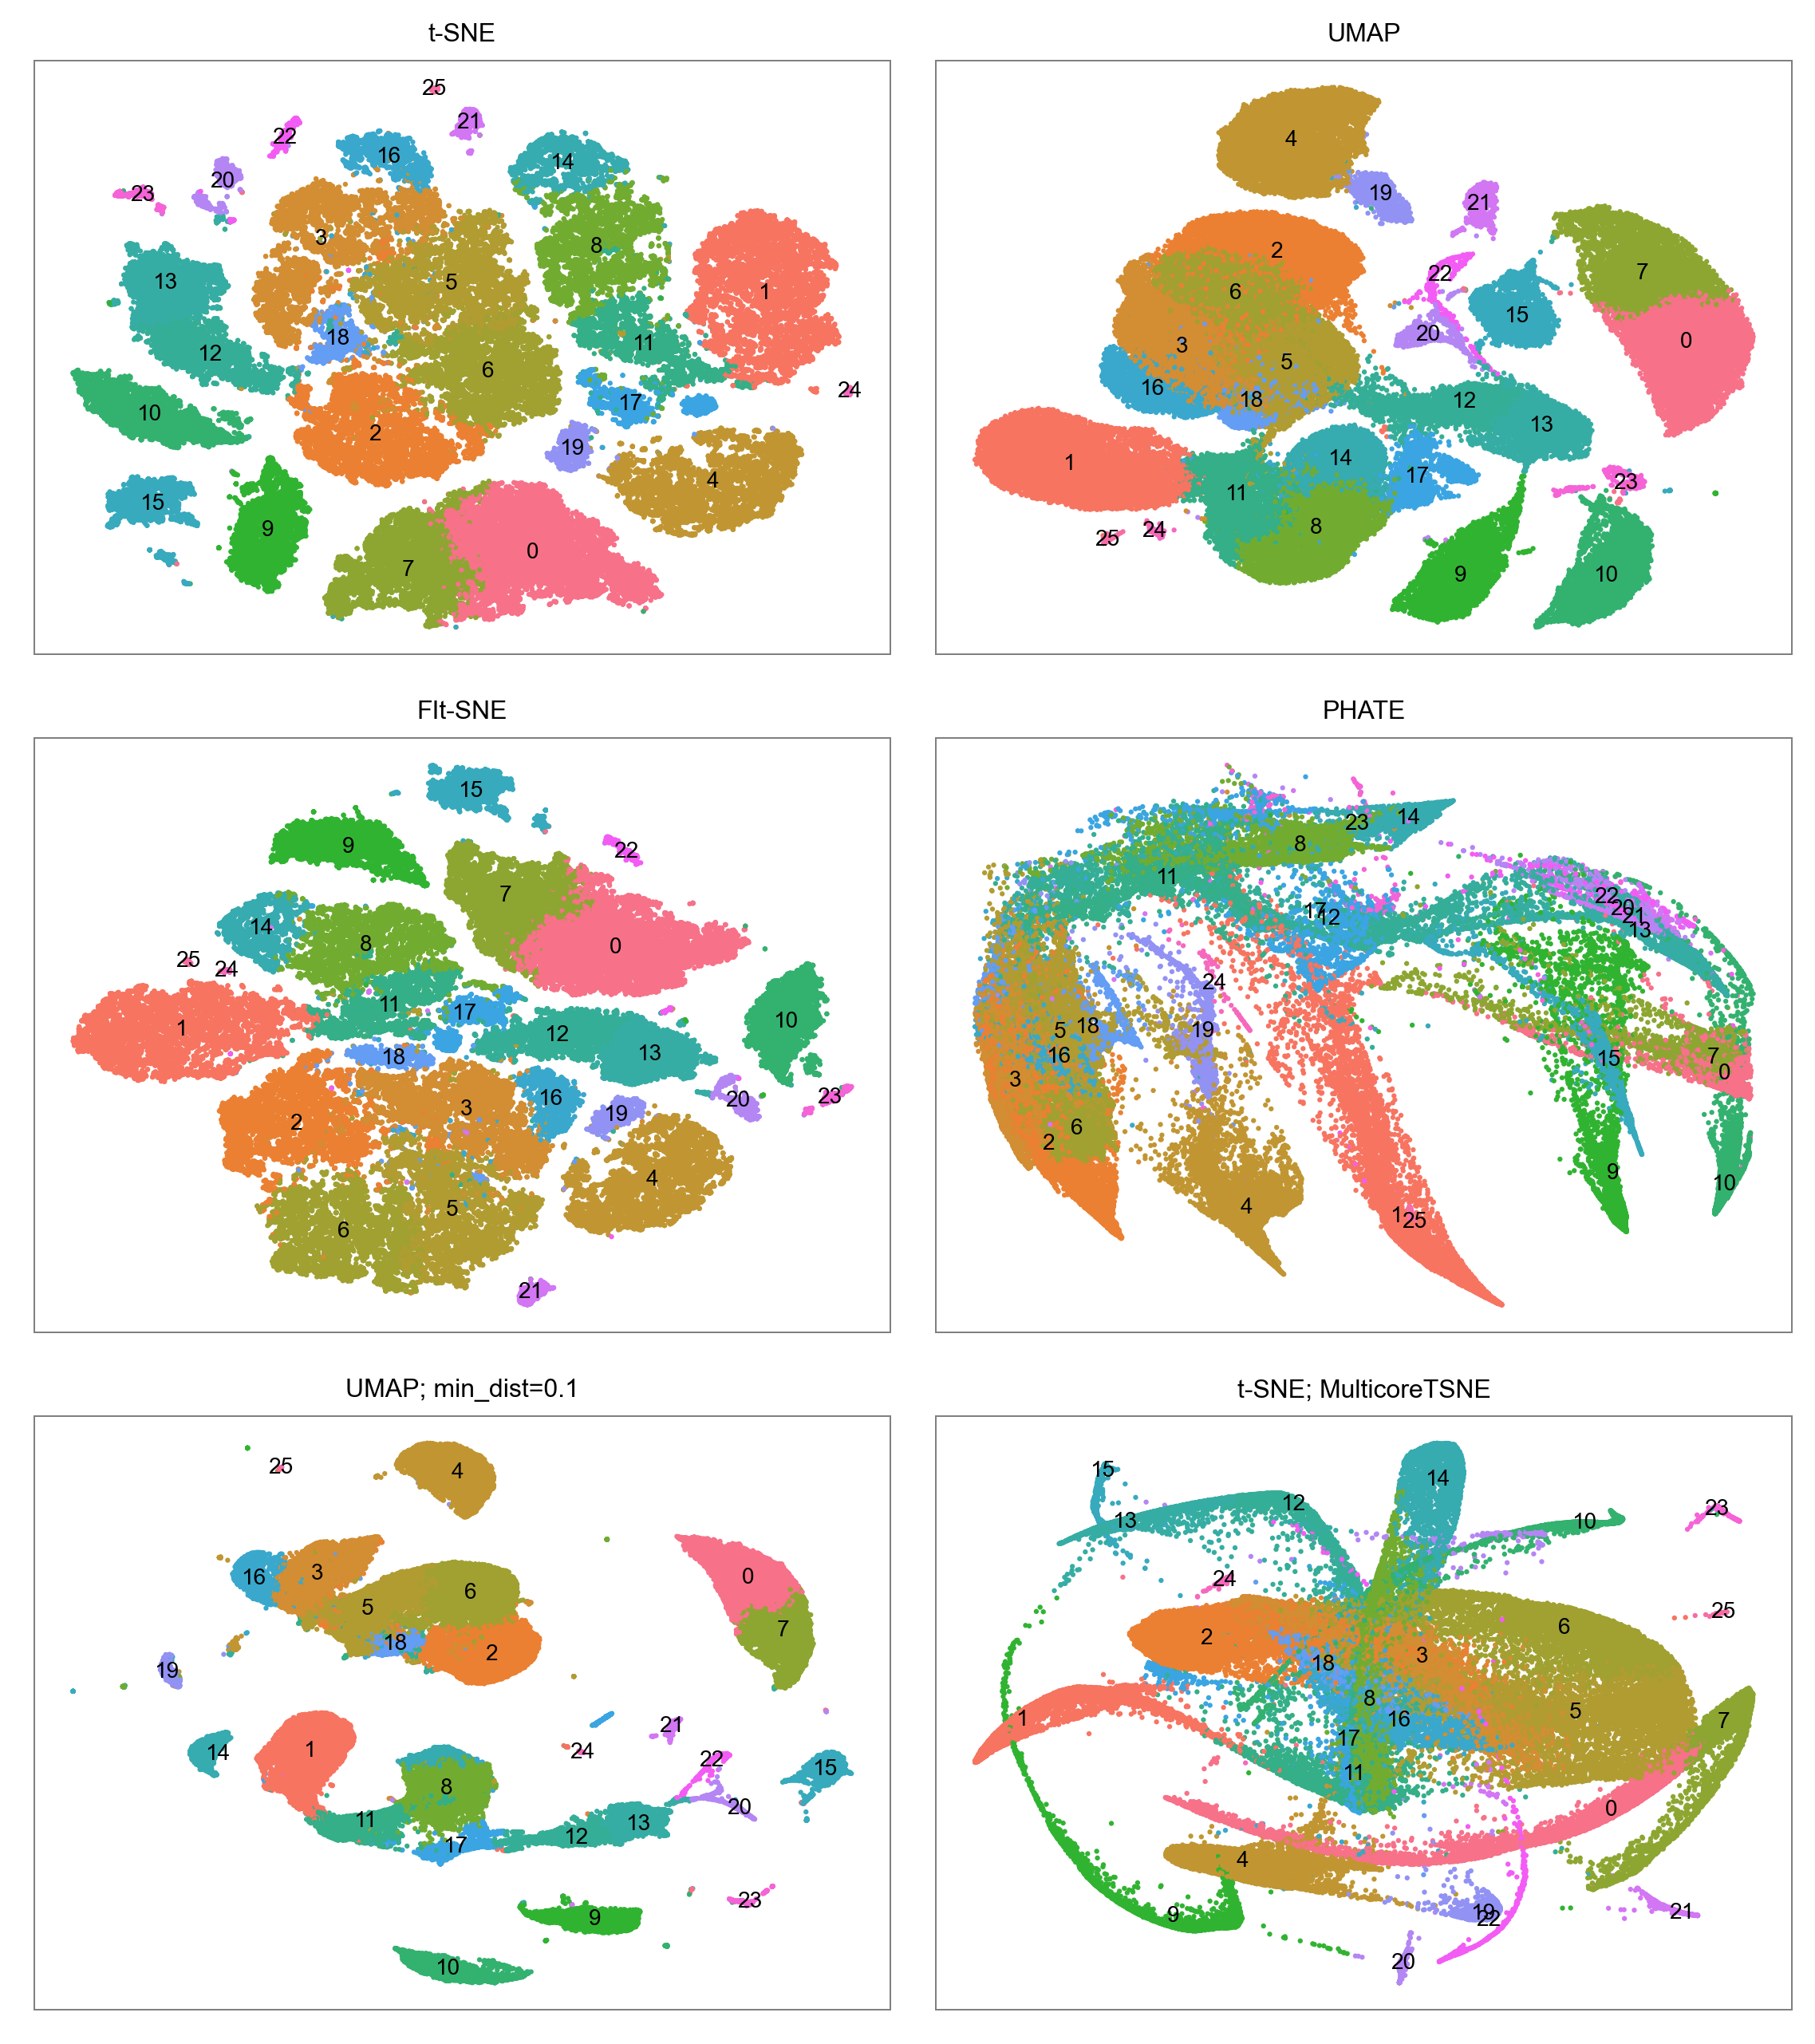

In [44]:
fig, axes = plt.subplots(nrows=1 * 3, ncols=1 * 2, figsize=(4 * 2, 3 * 3))
axes = axes.flatten()

plot_embedding(
    embedding=embedding[['x_tsne', 'y_tsne']],
    ax=axes[0],
    title='t-SNE',
    group=embedding['louvain'],
    show_group_labels=True,
)

plot_embedding(
    embedding=embedding[['x_umap', 'y_umap']],
    ax=axes[1],
    title='UMAP',
    group=embedding['louvain'],
    show_group_labels=True,
)

plot_embedding(
    embedding=embedding[['x_fitsne', 'y_fitsne']],
    ax=axes[2],
    title='FIt-SNE',
    group=embedding['louvain'],
    show_group_labels=True,
)

plot_embedding(
    embedding=embedding[['x_phate', 'y_phate']],
    ax=axes[3],
    title='PHATE',
    group=embedding['louvain'],
    show_group_labels=True,
)

plot_embedding(
    embedding=embedding[['x_min_dist=0.1', 'y_min_dist=0.1']],
    ax=axes[4],
    title='UMAP; min_dist=0.1',
    group=embedding['louvain'],
    show_group_labels=True,
)

plot_embedding(
    embedding=embedding[['x_multicoretsne', 'y_multicoretsne']],
    ax=axes[5],
    title='t-SNE; MulticoreTSNE',
    group=embedding['louvain'],
    show_group_labels=True,
)

plt.tight_layout()

In [45]:
file_name = ('Pyplot_embedding_'
             + 'ncomponents'
             + str(N_COMPONENTS_SELECTED)
             + '_'
             + 'seed'
             + str(SEED_USE)
             + '.pdf')

if not Path(file_name).is_file():
    fig.savefig(fname=file_name, transparent=None, bbox_inches='tight')

<a id='cluster_distribution'></a>

## Cluster distribution

<a id='batch'></a>

### Batch

In [46]:
embedding.groupby(by='batch').size().to_frame(name='num_cells')

num_cells
batch                 
SRR10480618       9874
SRR10480619       6662
SRR10480620       7894
SRR10480621       6989
SRR10480622       8044
SRR10480623       7994
SRR10480624       7534
SRR10480625       5065
SRR10480626       8482
SRR10480627       6852
SRR10480628       7915
SRR10480629       6468

In [47]:
embedding['batch'].unique()

array(['SRR10480618', 'SRR10480619', 'SRR10480620', 'SRR10480621',
       'SRR10480622', 'SRR10480623', 'SRR10480624', 'SRR10480625',
       'SRR10480626', 'SRR10480627', 'SRR10480628', 'SRR10480629'],
      dtype=object)

In [48]:
louvain_order = list(reversed(embedding['louvain'].sort_values().unique()))

In [49]:
batch_order = list(embedding['batch'].unique())

In [50]:
cluster_composition = prepare_cluster_composition(
    embedding=embedding,
    cluster_column='louvain',
    composition_column='batch',
    cluster_column_order=louvain_order,
    composition_column_order=batch_order
)

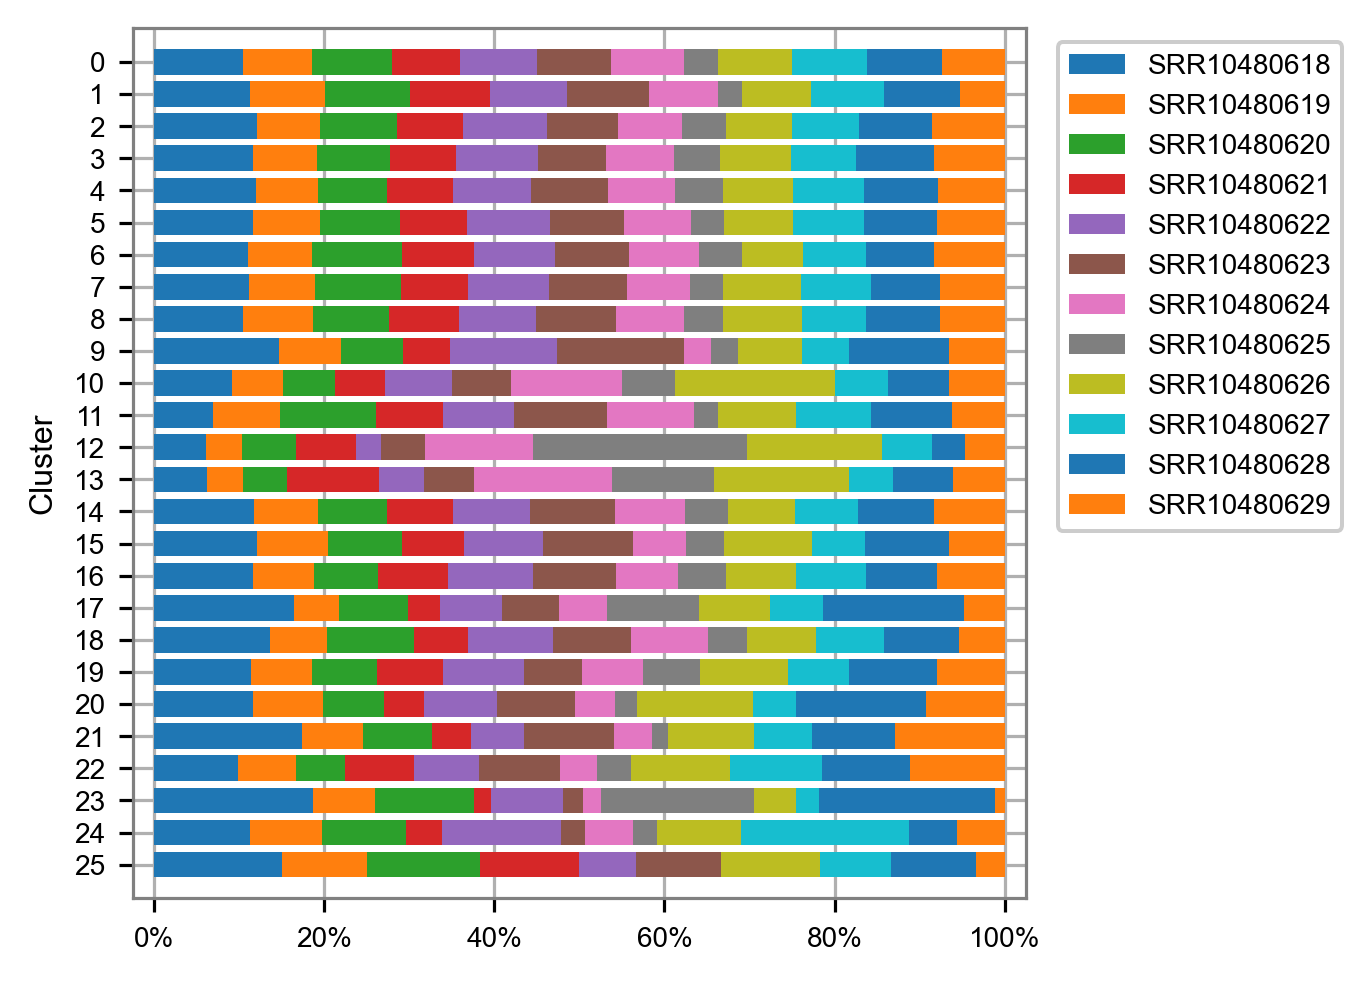

In [51]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

plot_cluster_composition(
    cluster_composition=cluster_composition,
    x='batch',
    y='louvain',
    ax=ax,
    x_order=batch_order,
    y_order=louvain_order
)

In [52]:
file_name = 'Pyplot_distribution_cluster.pdf'

if not Path(file_name).is_file():
    fig.savefig(fname=file_name, transparent=None, bbox_inches='tight')

<a id='batch_reversed'></a>

### Batch (reversed)

In [53]:
batch_composition = (
    embedding.groupby(by='batch').aggregate('louvain').value_counts()
    / embedding.groupby(by='batch').aggregate('louvain').size()
).to_frame(name='percentage').reset_index().fillna(value=0)

In [54]:
(embedding.groupby(by='batch').aggregate('louvain').value_counts()
    / embedding.groupby(by='batch').aggregate('louvain').size()
 ).to_frame(name='percentage').reset_index().pivot(
    index='batch',
    columns='louvain',
    values='percentage').sort_values(by='batch').T

batch    SRR10480618  SRR10480619  SRR10480620  SRR10480621  SRR10480622  \
louvain                                                                    
0           0.091452     0.105974     0.103370     0.098583     0.097340   
1           0.094896     0.111078     0.105397     0.112606     0.093113   
2           0.081831     0.074752     0.075880     0.074975     0.081427   
3           0.076970     0.073251     0.071573     0.072256     0.078568   
4           0.077780     0.069949     0.066126     0.070826     0.073222   
5           0.072818     0.073702     0.073980     0.070683     0.075584   
6           0.068159     0.069048     0.081708     0.074546     0.072352   
7           0.061677     0.063645     0.069673     0.061382     0.064396   
8           0.057525     0.067097     0.061186     0.063815     0.060915   
9           0.057322     0.042480     0.035850     0.030333     0.060666   
10          0.035852     0.034374     0.030023     0.032193     0.038165   
11          0.023901     0.040829     0.049151     0.038489     0.035679   
12          0.020762     0.021615     0.026983     0.034340     0.012307   
13          0.020559     0.021015     0.021662     0.050794     0.021382   
14          0.027041     0.025668     0.023436     0.025182     0.025609   
15          0.027648     0.028220     0.025082     0.023465     0.026355   
16          0.021369     0.019514     0.017228     0.021176     0.022750   
17          0.027446     0.012909     0.016975     0.008871     0.014794   
18          0.015191     0.011108     0.014315     0.010016     0.013799   
19          0.011039     0.010207     0.009248     0.010588     0.011313   
20          0.008305     0.008856     0.006461     0.004722     0.007583   
21          0.008305     0.005104     0.004814     0.003148     0.003605   
22          0.003950     0.004053     0.002914     0.004579     0.003729   
23          0.006482     0.003753     0.005067     0.001002     0.003605   
24          0.000810     0.000901     0.000887     0.000429     0.001243   
25          0.000911     0.000901     0.001013     0.001002     0.000497   

batch    SRR10480623  SRR10480624  SRR10480625  SRR10480626  SRR10480627  \
louvain                                                                    
0           0.094821     0.098089     0.068509     0.089484     0.111500   
1           0.100826     0.089992     0.046002     0.080288     0.104203   
2           0.070178     0.067029     0.067522     0.061424     0.076328   
3           0.065549     0.069419     0.069102     0.064018     0.073409   
4           0.073430     0.066897     0.070484     0.062839     0.077788   
5           0.067426     0.065171     0.047779     0.059538     0.075890   
6           0.066175     0.066499     0.061797     0.051757     0.065820   
7           0.063047     0.053624     0.042053     0.058595     0.066258   
8           0.063923     0.057871     0.048963     0.059774     0.059545   
9           0.072179     0.016326     0.024679     0.034072     0.031232   
10          0.033400     0.066764     0.047581     0.085239     0.035318   
11          0.046910     0.046987     0.018954     0.037020     0.044221   
12          0.021766     0.057207     0.167226     0.063311     0.029043   
13          0.024518     0.070613     0.077591     0.061896     0.024664   
14          0.028396     0.025086     0.022705     0.021221     0.024372   
15          0.029897     0.018848     0.019941     0.027470     0.020578   
16          0.021891     0.017786     0.020138     0.017567     0.021745   
17          0.013760     0.012477     0.035143     0.016152     0.014886   
18          0.012634     0.013273     0.010069     0.010493     0.012989   
19          0.008131     0.009026     0.012636     0.011672     0.009924   
20          0.008131     0.004513     0.003554     0.011436     0.005254   
21          0.006255     0.002787     0.001777     0.005659     0.004670   
22          0.004754     0.002256     0.003159 

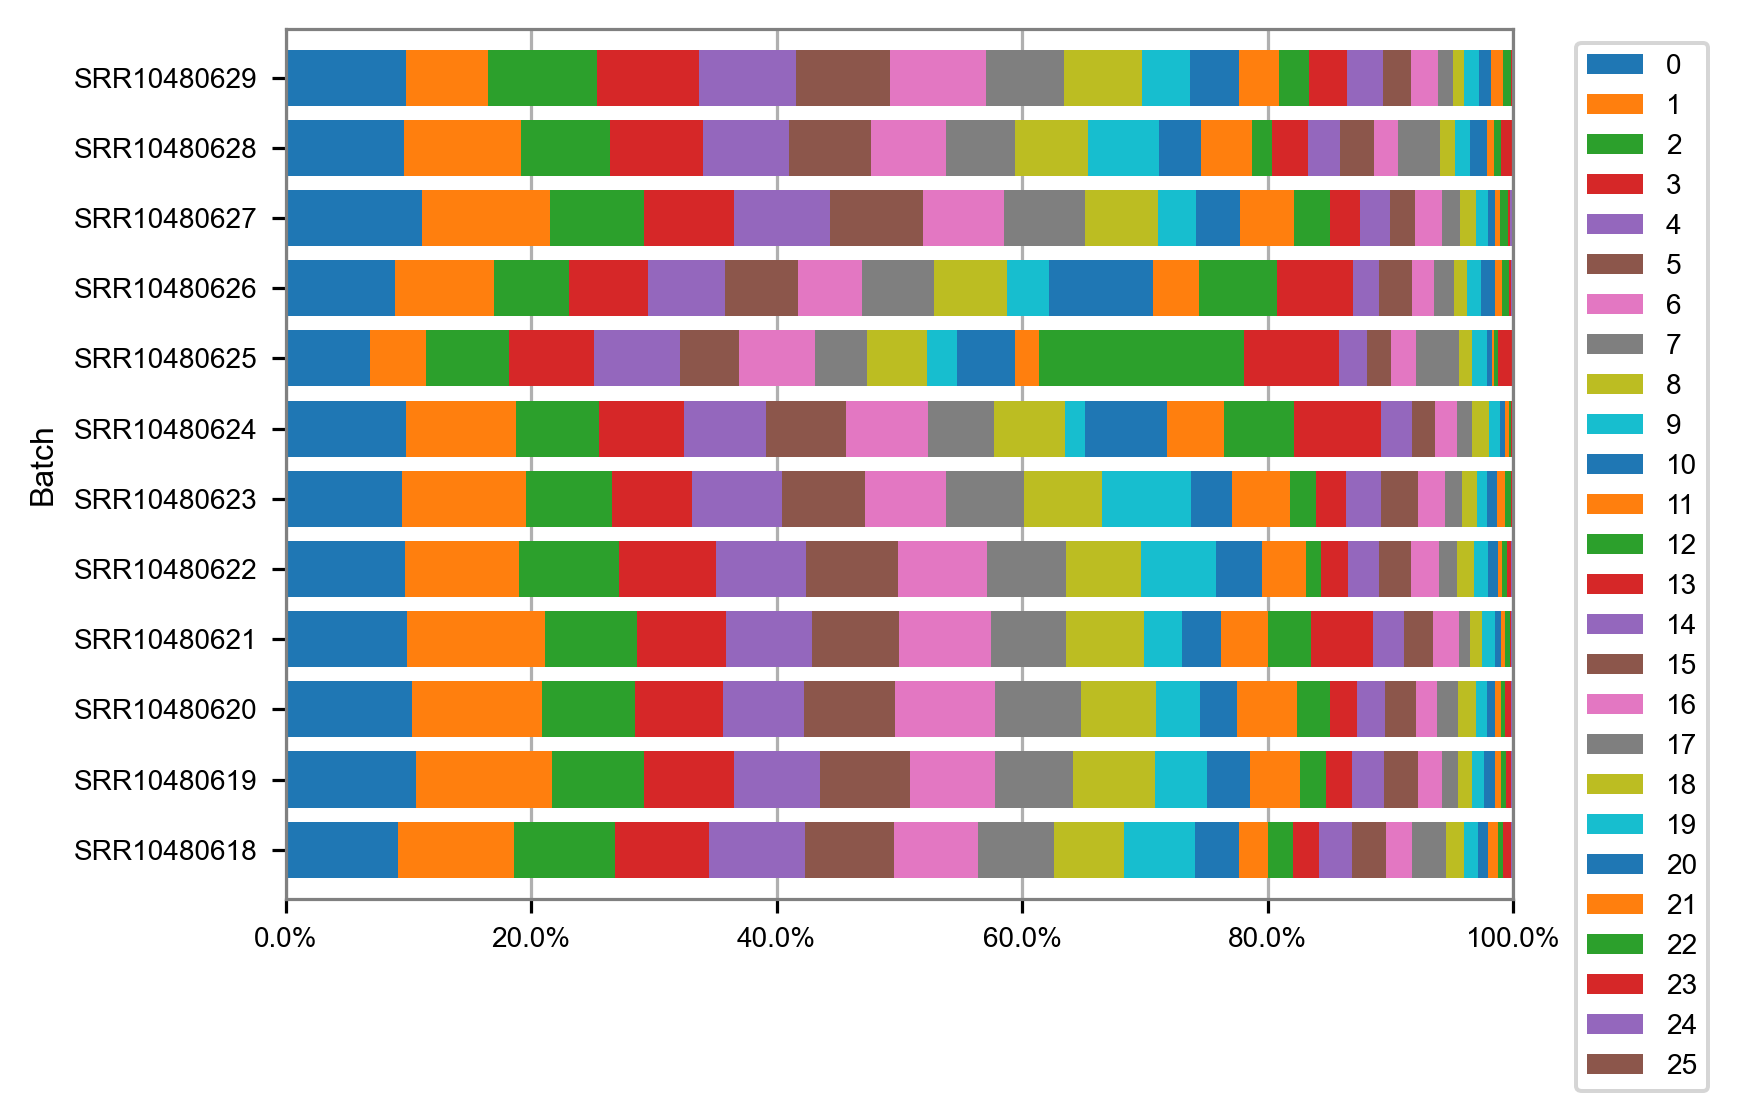

In [55]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5.5, 4))

left_positions = pd.Series(
    np.zeros(shape=batch_composition['batch'].nunique()))
left_positions.index = batch_composition.batch.unique()


p_handles = list()
for i in batch_composition['louvain'].sort_values().unique():

    batch_composition_subset = batch_composition.loc[
        batch_composition['louvain'] == i].sort_values(by='batch')

    batch_composition_subset = \
        batch_composition_subset.set_index(
            keys='batch',
            inplace=False).reindex(
            index=batch_composition['batch'].unique()
        ).fillna(value=0)

    p = ax.barh(y=batch_composition_subset.index,
                width=batch_composition_subset['percentage'],
                left=left_positions)

    p_handles.append(p[0])

    left_positions += batch_composition_subset['percentage']
    left_positions.fillna(value=0, inplace=True)


for i in ['top', 'bottom', 'left', 'right']:
    ax.spines[i].set_visible(b=True)
    ax.spines[i].set_linewidth(w=0.8)
    ax.spines[i].set_color(c='grey')

ax.tick_params(labelsize=7, labelcolor='black', direction='out')
ax.set_xticklabels(labels=[str(round(i * 100)) +
                           '%' for i in ax.get_xticks()], fontsize=7)
ax.set_yticks(ticks=range(batch_composition['louvain'].nunique()))

ax.set_xlabel(xlabel='', fontsize=8)
ax.set_ylabel(ylabel='Batch', fontsize=8)

ax.legend(handles=p_handles,
          labels=list(
              batch_composition['louvain'].sort_values().unique()
          ),
          # loc=1,
          bbox_to_anchor=(1.04, 1),
          loc='upper left',
          fontsize=7)

ax.margins(y=0.025)
plt.grid()

<a id='expression'></a>

## Expression

In [56]:
# load data
matrix_readcount_use = scipy.sparse.load_npz(
    file=DATA_DIR / 'matrix_readcount.npz')

matrix_readcount_use_barcodes = np.load(
    file=DATA_DIR / 'matrix_readcount_barcodes.npy')

matrix_readcount_use_features = np.load(
    file=DATA_DIR / 'matrix_readcount_features.npy')

In [57]:
# calculate CPM
matrix_cpm_use = matrix_readcount_use.copy()
matrix_cpm_use.data = (
    1_000_000
    * matrix_cpm_use.data
    / np.repeat(matrix_cpm_use.sum(axis=0).A1, np.diff(matrix_cpm_use.indptr))
)

In [58]:
# create anndata object, CPM

adata_cpm = sc.AnnData(
    X=matrix_cpm_use.T,
    obs={
        'cell': matrix_readcount_use_barcodes,
        'batch': [re.sub('_[A-Z]{16}$', '', i) for i in matrix_readcount_use_barcodes],
    },
    var={'feature': matrix_readcount_use_features},
)

adata_cpm.obs.index = adata_cpm.obs['cell']
adata_cpm.var.index = adata_cpm.var['feature']

In [59]:
[matrix_readcount_use_features[i]
 for i in np.where([re.search(pattern='HCN1', string=i.upper())
                    for i in matrix_readcount_use_features])]

[array(['ENSMUSG00000021730_Hcn1'], dtype='<U33')]

In [60]:
FEATURES_SELECTED = [
    'ENSMUSG00000036887_C1qa',
    'ENSMUSG00000015852_Fcrls',
    'ENSMUSG00000030579_Tyrobp',
    #
    'ENSMUSG00000024621_Csf1r' ,
    'ENSMUSG00000052336_Cx3cr1',
    'ENSMUSG00000036353_P2ry12'
]

C1qa
Fcrls
Tyrobp
Csf1r
Cx3cr1
P2ry12


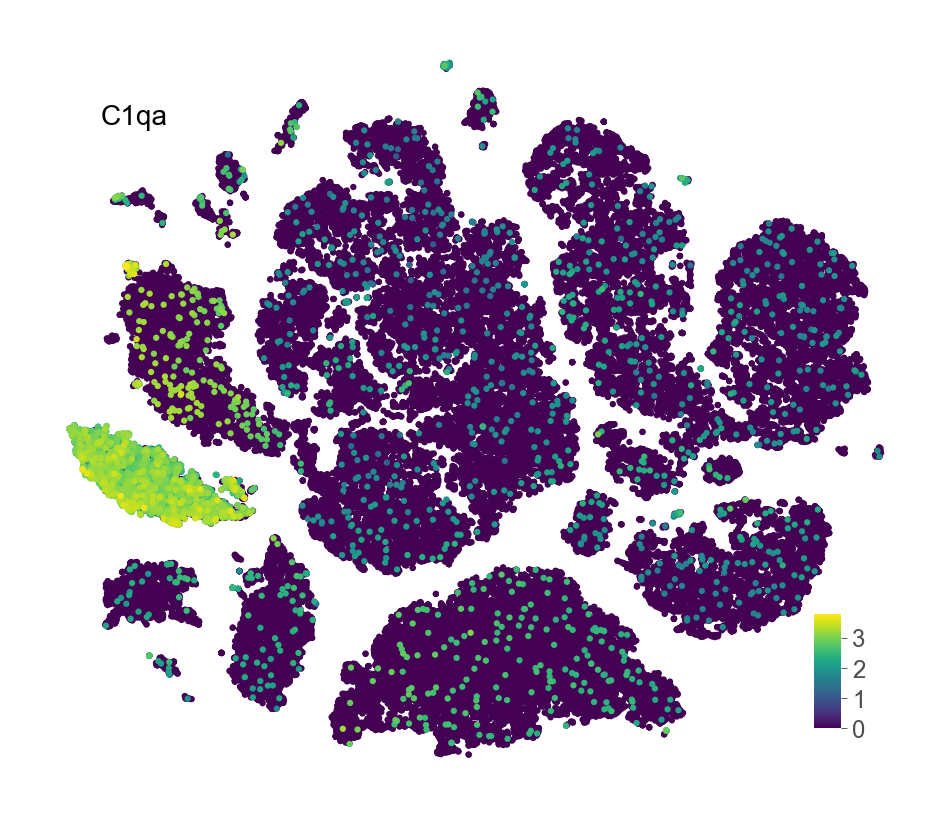

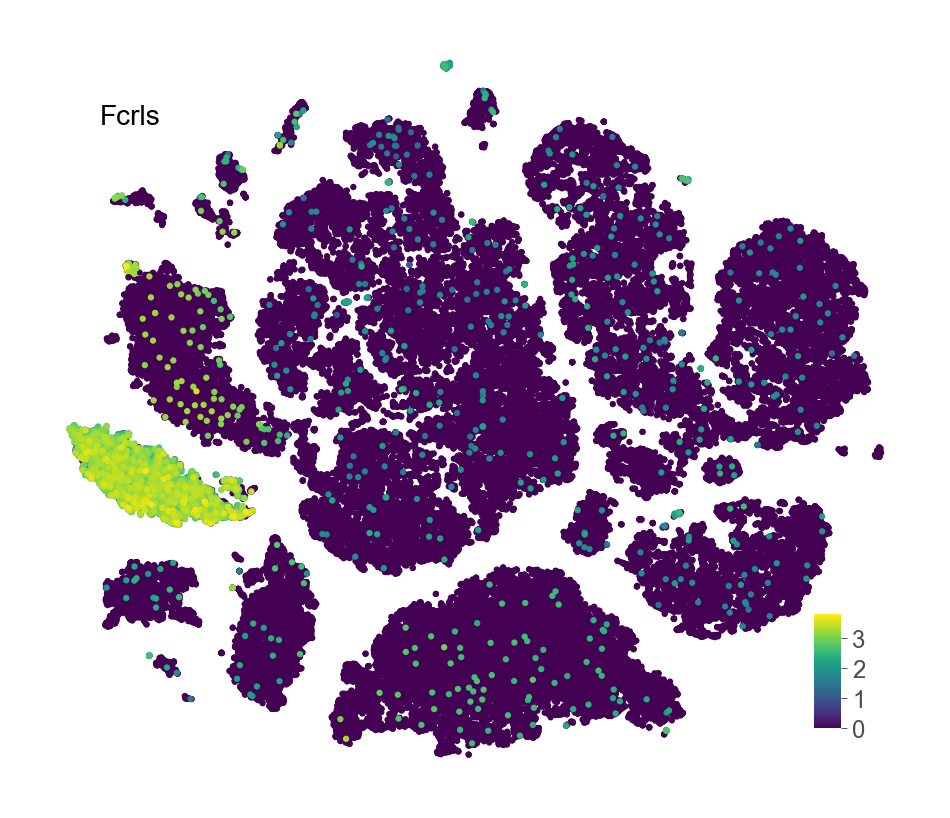

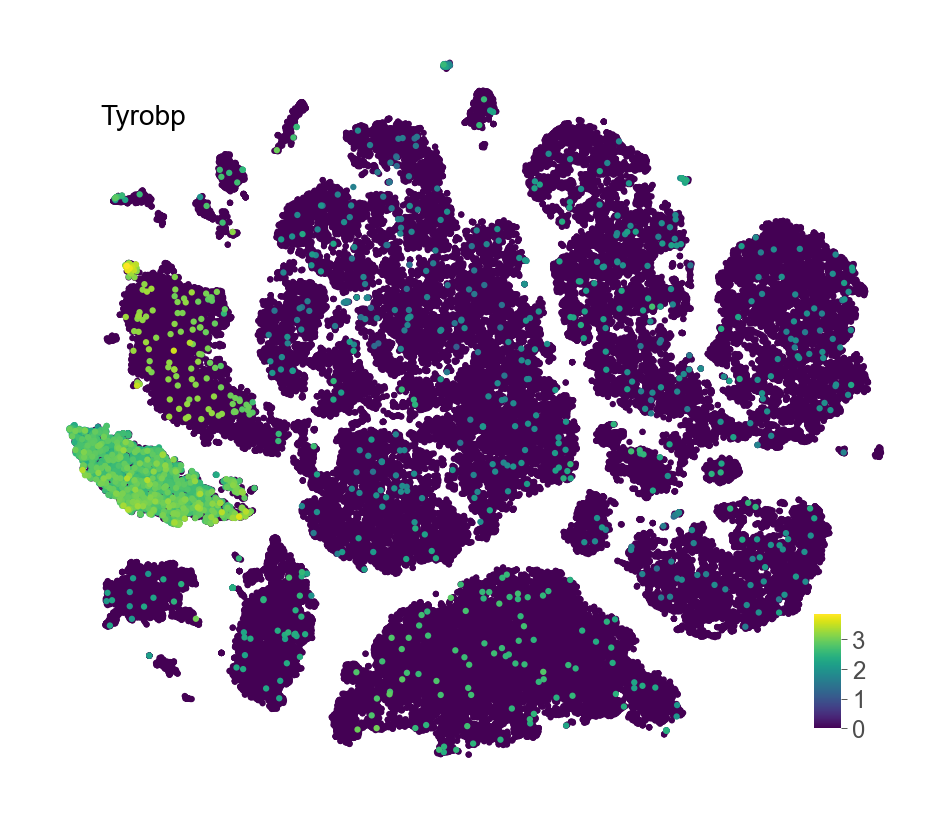

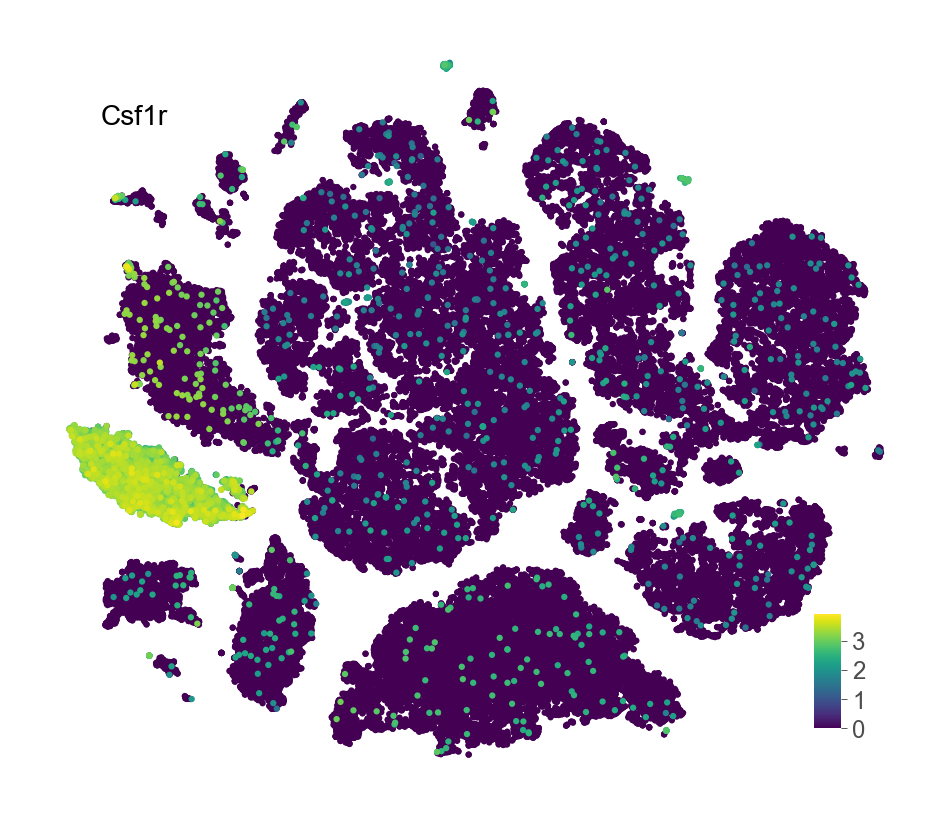

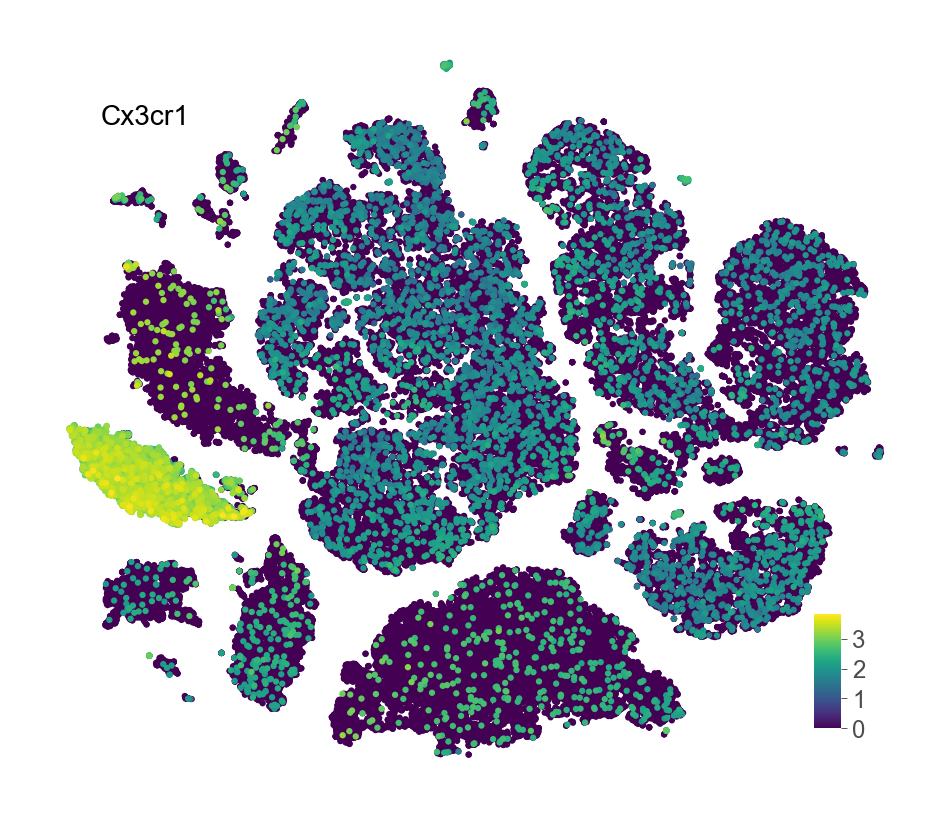

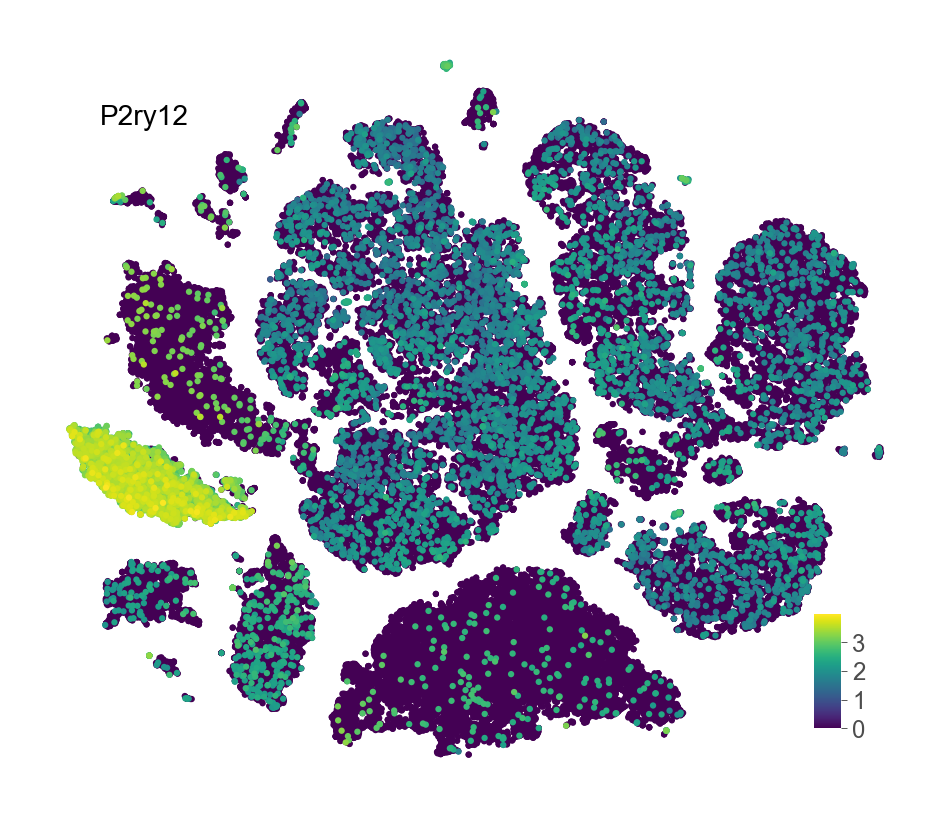

In [61]:
for i in FEATURES_SELECTED:
    print(i.split('_')[1])

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4 * 1, 3.5 * 1))

    plot_embedding_expr(
        embedding=embedding.loc[:, ['x_tsne', 'y_tsne']],
        expr=extract_feature_values(
            adata=adata_cpm,
            feature_name=i,
            cells_included=embedding.index,
        ),
        figure=fig,
        ax=ax,
        label=i.split('_')[1],
        label_position=(0.08, 0.9),
        colorbar_position=(0.88, 0.08, 0.03, 0.15)
    )

    """
    file_name = ('Pyplot_embedding_expr_'
                 + i
                 + '.pdf')

    if not Path(file_name).is_file():
        fig.savefig(fname=file_name, transparent=True)
    """